<a href="https://colab.research.google.com/github/mowglu/MNIST_Group_Classification/blob/main/Mini_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import random
from sklearn.model_selection import train_test_split
import cv2
import os
import pandas as pd
import itertools
import time

## Data Processing Functions

number_of_digits receives an image and finds the number of digits in the image.

It accomplishes this by summing the total pixel activations within a single column. It then checks if the activation is above some threshold (if not, the column's activation is rounded down to zero). Next, it groups together consecutive activations into individual "blobs". The total activation of these blobs is summed, and if it is above a threshold, it is counted as a digit. We also add an if-clause to take care of digits that are attached.

In [ ]:
# Receives 1 image and finds number of digits in this image

def number_of_digits(x):
    col_tot_activation = []
    for j in range(64):                       # Loops through all columns and sums total activation of pixels in a column
        pixel_sum = x[:,j].sum()
        col_tot_activation.append(pixel_sum)  # Appends to array 
    
    # If a columns activation is less than threshold, round it down to zero
    col_tot_activation = [x if x>50 else 0 for x in col_tot_activation]

    # Groups columns that are consecutively activated into individual blobs
    consecutive_activations = [ list(x[1]) for x in itertools.groupby(col_tot_activation, lambda x: x == 0)]

    # The sums of activations of each "blob" is calculated
    blob_sums = [np.sum(i) for i in consecutive_activations]

    # If the blob's total activation is over threshold, it is a digit
    num_digits = sum(1 for i in blob_sums if i>750)

    # Finds if two digits are attached and adjusts num_digits if so
    max_len = max([len(x) for x in consecutive_activations if np.sum(x) > 0])
    if max_len > 15:
        num_digits += 1

    # No longer needed, but will keep for redundancy for the private dataset
    if num_digits > 5:
        num_digits = 5
    return num_digits

digit_splitter receives an image and splits it at pre-determined points. We find that each digit is ~12 columns, and centered along the image. Thus, we return groups of 12 columns, each group representing a digit.

We visualized many examples of 1, 2, 3, 4, and 5 digit splits and adjusted our split points as needed.

In [ ]:
# Receives a single image and splits into multiple images at pre-determined points

def digit_splitter(x, y, num_digits):
    split_images = []
    if num_digits == 5:
        split_images.append(x[:,2:14,:])        # keeps all rows, keeps columns 2 (inclusive) to 14 (not inclusive), keeps 3rd dimension
        split_images.append(x[:,14:26,:])
        split_images.append(x[:,26:38,:])
        split_images.append(x[:,38:50,:])
        split_images.append(x[:,50:62,:])
        split_y_vals = y[:5]                    # keeps the first 5 y-values
    elif num_digits == 4:
        split_images.append(x[:,8:20,:])  
        split_images.append(x[:,20:32,:])  
        split_images.append(x[:,32:44,:])  
        split_images.append(x[:,44:56,:])
        split_y_vals = y[:4]
    elif num_digits == 3:
        split_images.append(x[:,14:26,:])
        split_images.append(x[:,26:38,:])
        split_images.append(x[:,38:50,:])
        split_y_vals = y[:3]
    elif num_digits == 2:
        split_images.append(x[:,20:32,:])  
        split_images.append(x[:,32:44,:]) 
        split_y_vals = y[:2]
    elif num_digits == 1:
        split_images.append(x[:,26:38,:])
        split_y_vals = y[:1]
    return split_images, split_y_vals

## Import Data

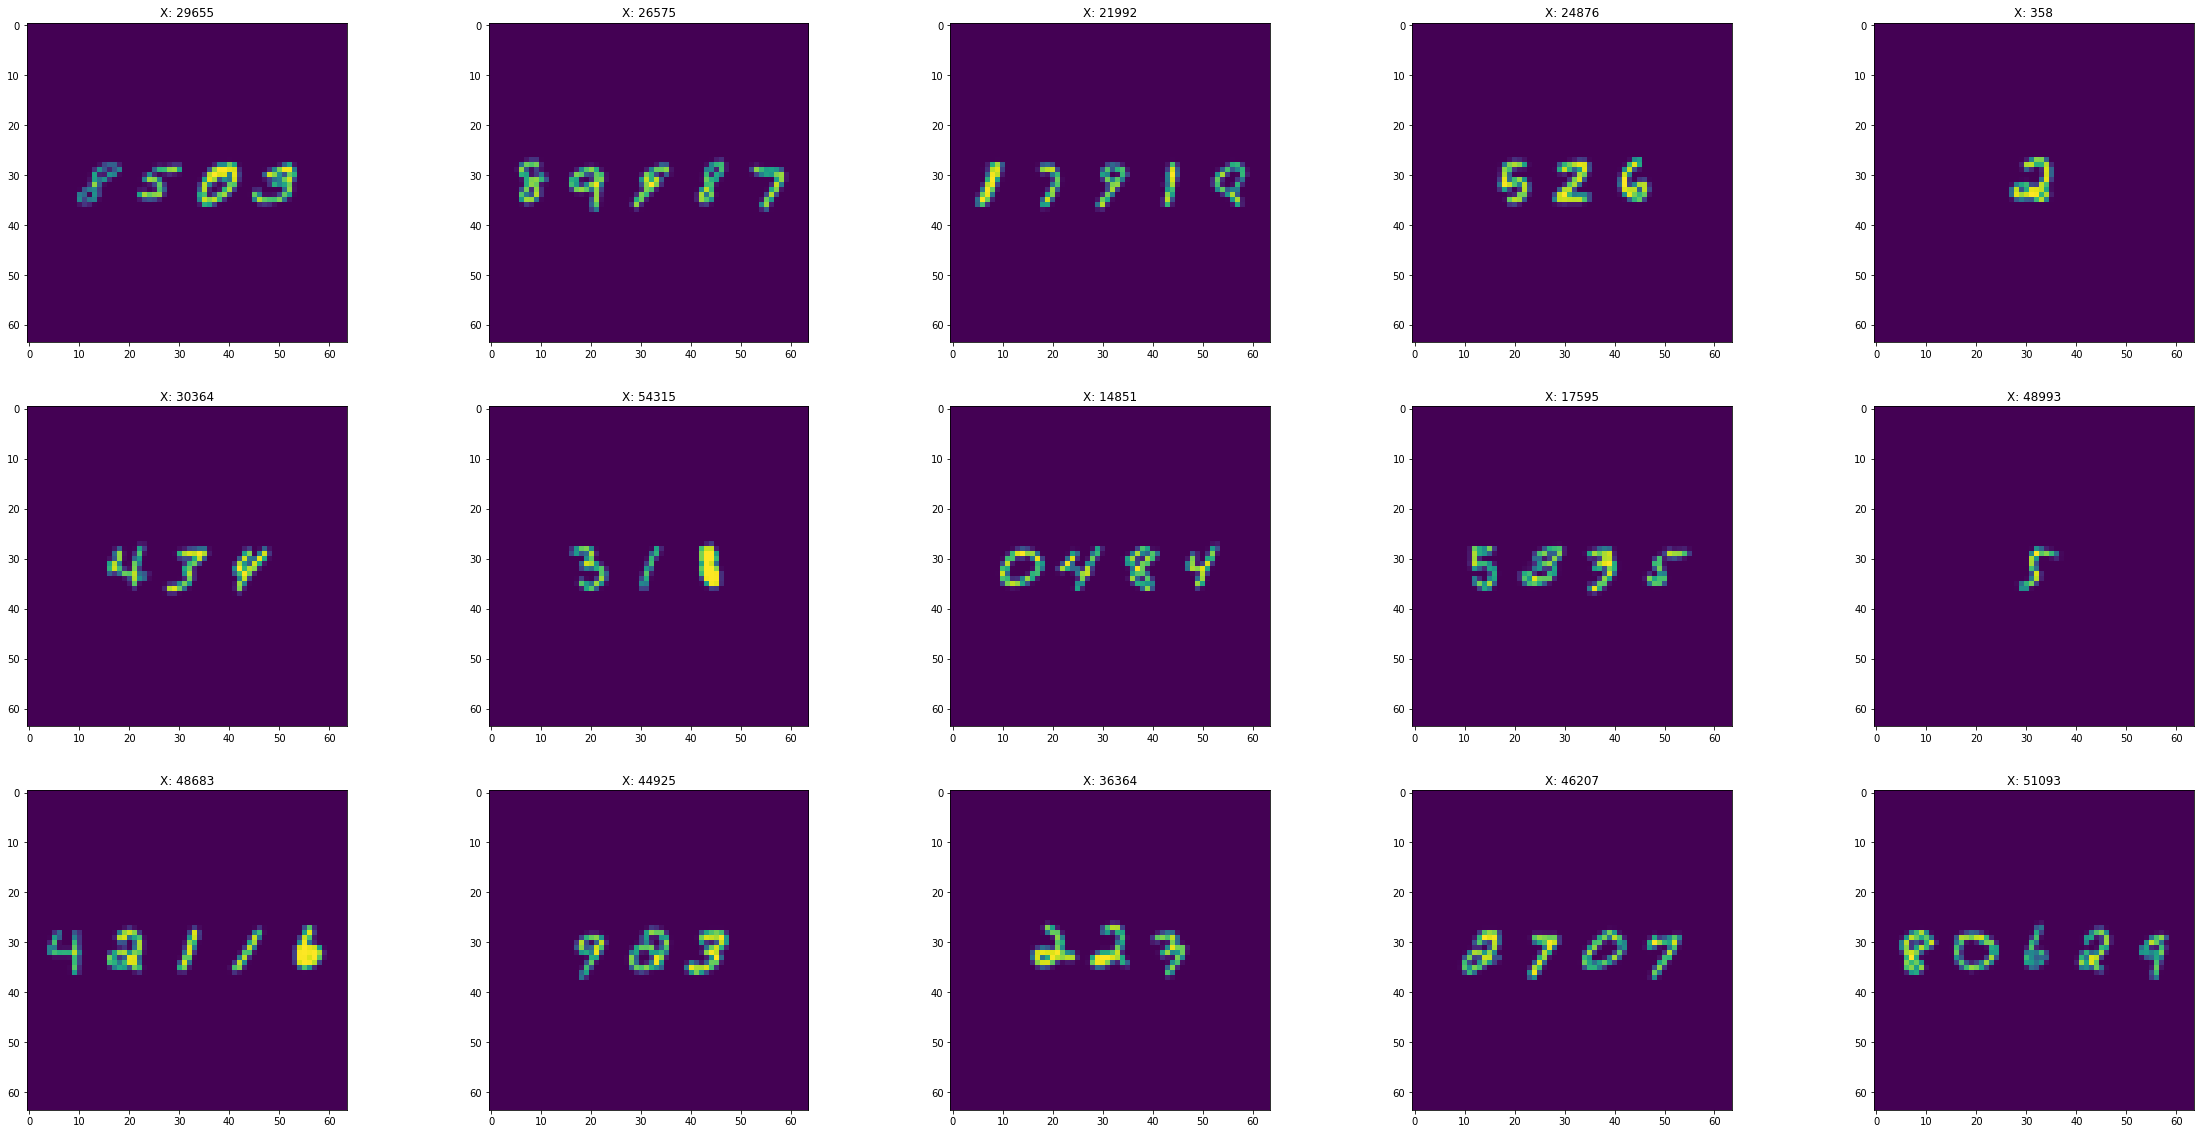

In [ ]:
# Import data

dataset = h5py.File("MNIST_synthetic.h5", 'r')
x = np.array(dataset['train_dataset'])
y = np.array(dataset['train_labels'])

# Plot sample of data 
plt.figure(figsize=(40,20))
for i in range(15):
    rand = np.random.randint(0,55999)        # Use this to plot random sample if desired
    plt.subplot(3,5,i+1), plt.imshow(x[i,:,:,0])
    plt.title("X: %d" % rand),plt.xticks([0,10,20,30,40,50,60]), plt.yticks([0,10,20,30,40,50,60])
plt.show()

## Remove Unnecessary Rows

This cells determines which rows do not contirbute useful infrmation, and removes them. This following cell does not need to be re-run.


In [ ]:
# Determine which rows are at the top of the image are completely zero

first_row = []
for a in range(len(x)):             #Iterate through all images
    exit = False
    for i in range(64):             #Iterate through all rows within an image
        for j in range(64):         #Iterate through all columns within an image 
            if x[a][i][j] != 0:     #If a pixel has a non-zero value, break loop
                exit = True
                break
        if exit:
            first_row.append(i)     #Store the row that has the first non zero value
            break

# Determine which rows are at the bottom of the image are completely zero

last_row = []
for a in range(len(x)):             #Iterate through all images
    exit = False
    for i in range(-1,-65,-1):      #Iterate through all rows within an image
        for j in range(64):         #Iterate through all columns within an image 
            if x[a][i][j] != 0:     #If a pixel has a non-zero value, break loop
                exit = True
                break
        if exit:
            last_row.append(i)     #Store the row that has the first non zero value for each image
            break


print(min(first_row), max(last_row))    # Every row before row 26 and after -27 can be discarded safely


26 -27


This cell adjusts x to only have those rows which are needed, and re-plots with adjusted rows (this code needs to be re-run):

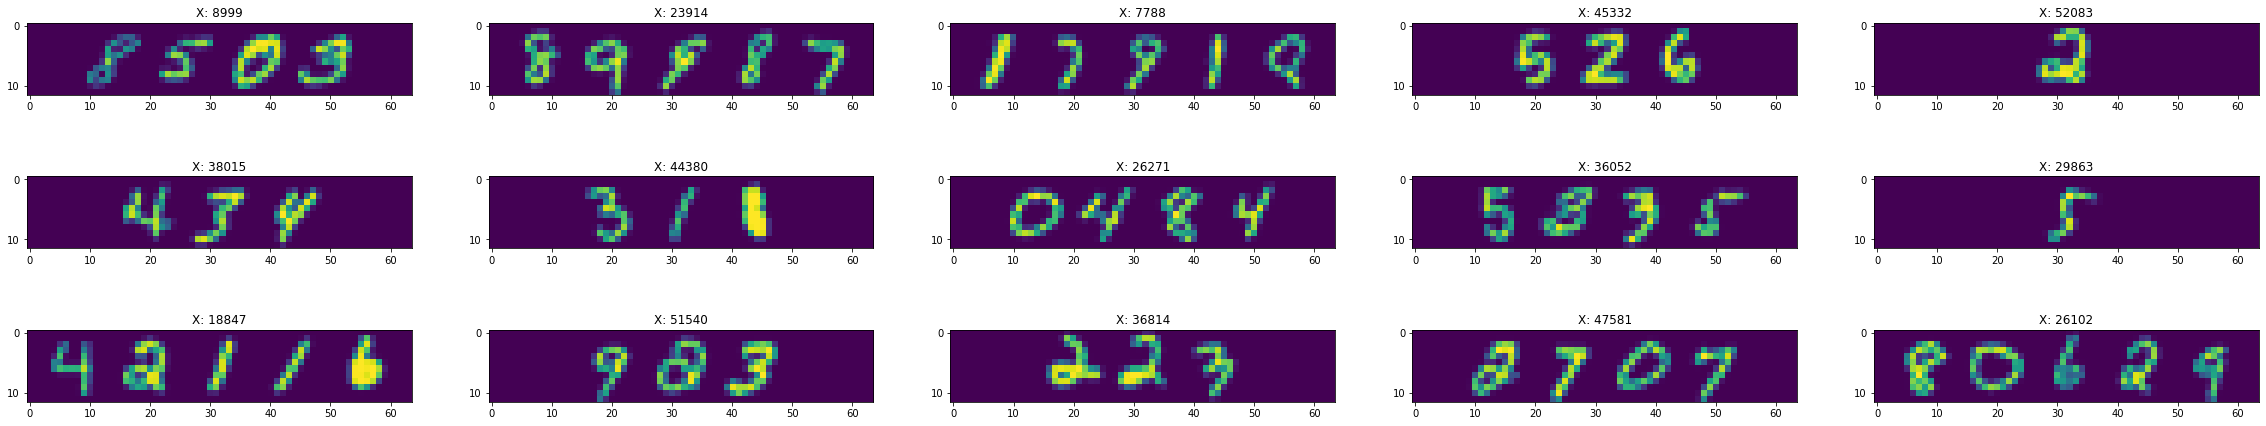

In [ ]:
# Plot sample with adjusted rows

x = x[:,26:-26,:,:]
plt.figure(figsize=(40,8))
for i in range(15):
    rand = np.random.randint(0,55999)
    plt.subplot(3,5,i+1), plt.imshow(x[i,:,:,0])
    plt.title("X: %d" % rand),plt.xticks([0,10,20,30,40,50,60]), plt.yticks([0,10])
plt.show()

### Extracting Individual Digits

This cell finds the number of digits using our function and tests its accuracy. It also records the following data for visualization and tuning purposes: correctly classified images, incorrectly classified images, true number of digits.

In [ ]:
# Find number of digits in an image and compare to actual number of digits with y-label

misdigit_ind = [] 
misdigit_pics = []
misdigits_arr = []
x_copy = []
y_copy = []
true_num_arr = []

for i in range(len(x)):
    num_digits = number_of_digits(x[i])                 # Gets guess from number_of_digits function
    true_num_digits = np.count_nonzero(y[i] != 10);     # Actual value of the number of digits
    true_num_arr.append(true_num_digits)
    if num_digits != true_num_digits:                   # If incorrect, append incorrect image, num_digits guess, and index to misdigit for future visualization
        misdigit_ind.append(i)
        misdigit_pics.append(x[i])
        misdigits_arr.append(num_digits)
    else:                                               # If correct, append correct image and y-label to x_copy
        x_copy.append(x[i]) 
        y_copy.append(y[i]) 

# x_copy and y_copy are the images that num_digits was able to correctly identify
# If accuracy cannot reach 100%, only these will be used for training
x_copy = np.array(x_copy)
y_copy = np.array(y_copy)

# Calculate accuracy of num_digits
digit_accuracy = (len(x) - len(misdigits_arr))*100/len(x)
print(f"The digitization accuracy is {digit_accuracy}%!")

misdigit_pics = np.array(misdigit_pics)

The digitization accuracy is 100.0%!


We then attempt to split our images into individual digits. This requires some tuning, thus we visualize several splits by adjusting the size of the range() function. Eventually, we reach near-perfect splits

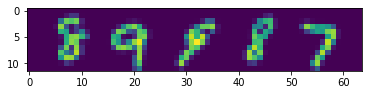

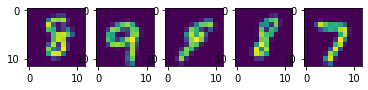

In [ ]:
one_dig_ind = [i for i, num in enumerate(true_num_arr) if num == 1]
two_dig_ind = [i for i, num in enumerate(true_num_arr) if num == 2]
three_dig_ind = [i for i, num in enumerate(true_num_arr) if num == 3]
four_dig_ind = [i for i, num in enumerate(true_num_arr) if num == 4]
five_dig_ind = [i for i, num in enumerate(true_num_arr) if num == 5]

for a in range(1):
    num_digits = np.count_nonzero(y[five_dig_ind[a]] != 10)
    split_images, split_y = digit_splitter(x_copy[five_dig_ind[a],:,:], y_copy[five_dig_ind[a],:], num_digits)
    
    split_images = np.array(split_images)
    split_y = np.array(split_y)
    
    plt.figure(1)
    plt.imshow(x_copy[five_dig_ind[a],:,:,0])

    for j in range(num_digits):
        plt.figure(2)
        plt.subplot(1,num_digits,j+1), plt.imshow(split_images[j,:,:,0])
    plt.show()

Once the split points are determined, we split the entire data set into x_singles and y_singles, which are a single digit and its corresponding label. This will be used for training our model.

In [ ]:
x_singles = []
y_singles = []

for a in range(len(x)):
    num_digits = number_of_digits(x[a])
    # num_digits = np.count_nonzero(y[a] != 10)
    split_x, split_y = digit_splitter(x[a], y[a], num_digits)  # Splits image and labels
    x_singles.append(split_x)                                  # Appends images and labels
    y_singles.append(split_y)


# Flattens the lists such that each instance is a single image
x_grouped = x_singles
y_grouped = y_singles
x_singles = [item for sublist in x_singles for item in sublist]
y_singles = [item for sublist in y_singles for item in sublist if not item == 10]



We run some tests to ensure x_singles and y_singles are of the correct shape and length.

In [ ]:
print("Length of x_singles and y_singles are:",len(x_singles), len(y_singles))
print("Shape of one instance of x_singles is:", x_singles[0].shape)
print("Shape of one instance of y_singles is (its just a number, has no shape):", y_singles[0].shape)

Length of x_singles and y_singles are: 167886 167886
Shape of one instance of x_singles is: (12, 12, 1)
Shape of one instance of y_singles is (its just a number, has no shape): ()


In [ ]:
# Checks all x_singles are correct dimensions
total_dimensions = [True for item in x_singles if (np.shape(item))  == (12, 12, 1)]
pd.Series(total_dimensions).value_counts()

True    167886
dtype: int64

In [ ]:
# Checks all y_singles are correct dimensions
total_dimensions = [True for item in y_singles if (np.shape(item))  == ()]
pd.Series(total_dimensions).value_counts()

True    167886
dtype: int64

### Using a CNN Model

In [ ]:
from keras.datasets import mnist
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import keras.optimizers as optimizers
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D,MaxPool2D
import tensorflow as tf
import keras
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# load train and test dataset
def load_dataset(x_singles,y_singles):
    # load dataset
    from sklearn.model_selection import train_test_split
    trainX, testX, trainY, testY = train_test_split(x_singles, y_singles,test_size = 0.25)
    trainX = np.array(trainX)
    testX = np.array(testX)
    trainY = np.array(trainY)
    testY = np.array(testY)
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 12, 12, 1))
    testX = testX.reshape((testX.shape[0], 12, 12, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [ ]:
# scale pixels
def prep_pixels(train, test):
 	# convert from integers to floats
 	train_norm = train.astype('float32')
 	test_norm = test.astype('float32')
 	# normalize to range 0-1
 	train_norm = train_norm / 255.0
 	test_norm = test_norm / 255.0
 	# return normalized images
 	return train_norm, test_norm

In [ ]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal', input_shape=(12, 12, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
    # model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='normal'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = keras.optimizers.Adagrad(lr=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()


# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

> 99.492
> 99.516
> 99.448
> 99.448
> 99.575


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


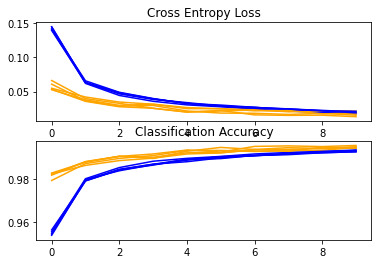

Accuracy: mean=99.496 std=0.047, n=5


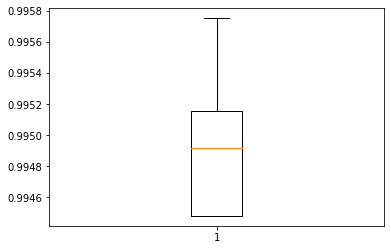

In [ ]:
# run the test harness for cross validation and accuracy plots
def cross_validation():
	# load dataset
	trainX, trainY, testX, testY = load_dataset(x_singles,y_singles)
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 
# entry point, run the test harness
cross_validation()

In [ ]:
# Entire training dataset
x_train = x_singles
y_train = y_singles

x_train = np.array(x_train)
y_train = np.array(y_train)

# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 12, 12, 1))

# one hot encode target values
y_train = to_categorical(y_train)

x_train = x_train.astype('float32')
# normalize to range 0-1
x_train = x_train / 255.0


In [ ]:
# run the test harness for saving model with 10 Epochs first
def save_model():
  model = define_model()
  # fit model
  model.fit(x_train, y_train, epochs=100, batch_size=16, verbose=0)
  # save model
  model.save('final_model_V0.h5')  

start = time.time()
# entry point, run the test harness
save_model()
end = time.time()

print(end-start)

2092.0035762786865


In [ ]:
# Evaluating the model
model = load_model('final_model_V0.h5', compile=False)
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
_, acc = model.evaluate(x_train, y_train, verbose=0)
print('> %.3f' % (acc * 100.0))


> 99.996


## Visualizing on Entire (Training) Dataset

The cross validation plots are satisfactory enough. But can we visualize where the model made mistakes with the dataset, and somehow try and account for those cases?

In [ ]:
def load_image(x_sngl):
    # load the image
    img = x_sngl
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 12, 12, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img


In [ ]:
# digit splitter without labels y
def test_digit_splitter(x, num_digits):
    split_images = []
    if num_digits == 5:
        split_images.append(x[:,2:14,:])        # keeps all rows, keeps columns 2 (inclusive) to 14 (not inclusive), keeps 3rd dimension
        split_images.append(x[:,14:26,:])
        split_images.append(x[:,26:38,:])
        split_images.append(x[:,38:50,:])
        split_images.append(x[:,50:62,:])
    elif num_digits == 4:
        split_images.append(x[:,8:20,:])  
        split_images.append(x[:,20:32,:])  
        split_images.append(x[:,32:44,:])  
        split_images.append(x[:,44:56,:])
    elif num_digits == 3:
        split_images.append(x[:,14:26,:])
        split_images.append(x[:,26:38,:])
        split_images.append(x[:,38:50,:])
    elif num_digits == 2:
        split_images.append(x[:,20:32,:])  
        split_images.append(x[:,32:44,:]) 
    elif num_digits == 1:
        split_images.append(x[:,26:38,:])
    return split_images

# loads test set without the need of labels y
def load_test_set(x_test):

    x_test_singles = []
    
    for a in range(len(x_test)):
        num_digits = number_of_digits(x_test[a])
        split_x = test_digit_splitter(x_test[a], num_digits)  # Splits image
        x_test_singles.append(split_x)                        # Appends images

    return x_test_singles

In [ ]:
# loading model and trying to see patterns in training dataset. We can artificially include biases for wrongly classified digits

misclassify_pics = []
misclassify_arr = []
misclassify_labels = []

model = load_model('final_model_V0.h5', compile=False)

x_singles = np.array(x_singles)
y_singles = np.array(y_singles)

for i in range(len(x_singles)):
    if i == 1000:
      print('here')
    if i == 10000:
        print('here')
    if i == 50000:
        print('here')
    if i == 100000:
        print('here')
    if i == 110000:
        print('here')
    if i == 120000:
        print('here')
    if i == 130000:
        print('here')
    if i == 140000:
        print('here')
    if i == 150000:
        print('here')
        
    img = load_image(x_singles[i])
    digit = model.predict_classes(img)
    if digit != y_singles[i]:
        misclassify_pics.append(x_singles[i])
        misclassify_arr.append(digit)
        misclassify_labels.append(y_singles[i])


misclassify_pics = np.array(misclassify_pics)
print(f"From the entire training data that is split image-by-image, the model predicts with accuracy {(1-misclassify_pics.shape[0]/x_singles.shape[0])*100}")

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
here
here
here
here
here
here
here
here
here
From the entire training data that is split image-by-image, the model predicts with accuracy 99.99940435771893


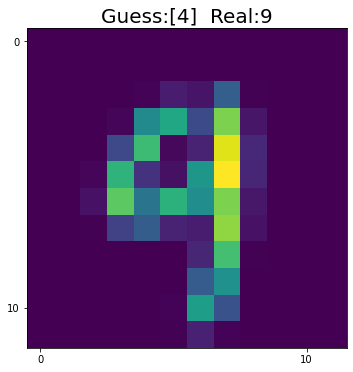

In [ ]:
# Visualization of the first 15 wrongly classified images. Unfortunately, no patterns were seen, so there's no intuition on 
# what biases to artificially include.

plt.figure(figsize = (40,20))
for i in range(1):
    title_list = [misclassify_arr[i],misclassify_labels[i]]
    plt.subplot(3,5,i+1), plt.imshow(misclassify_pics[i,:,:,0])
    plt.title(f"Guess:{title_list[0]}  Real:{title_list[1]}",fontsize = 20),plt.xticks([0,10]), plt.yticks([0,10])
plt.show()

## Final Predictions on Test Set

In [ ]:
# function takes image, makes prediction and appends result to y_pred list
def pred(x_tst, y_pred):

    # load model
    model = load_model(f'final_model_V0.h5', compile=False)

    for i in range (len(x_tst)):
        y_str = ""
        for j in range (len(x_tst[i])):
            img = load_image(x_tst[i][j])
            # predict the class
            digit = model.predict_classes(img)
            y_str = y_str + str(digit[0])

        #add 10 at the end for missing digits
        for k in range(5-len(y_str)):
            y_str = y_str + '10'
        y_pred.append(y_str)

    return y_pred


In [ ]:
# initializing list that will hold all of our predictions
y_pred=[]

In [ ]:
# Evaluate on Test Set

start = time.time()

#load test data from original dataset
x_test = np.array(dataset['test_dataset'])

#Taking a subset of the dataset to prevent deepnote from crashing
x_test = x_test[0:14000,:,:,:]


# remove unused rows
x_test = x_test[:,26:-26,:,:]

#load_test_set() takes in the original data and splits it into sepearate digits
x_tst = load_test_set(x_test)

#pred() returns a list of all the prediction
pred(x_tst, y_pred)

end = time.time()
print(end-start)

1175.7576973438263


In [ ]:
# Check how many images have been predicted so far
len(y_pred)

14000

In [ ]:
submission = pd.Series(y_pred)
len(submission)

14000

In [ ]:
# converting merged dataframe into csv file
submission.to_csv('file_to_submit.csv')
print(len(submission))

14000


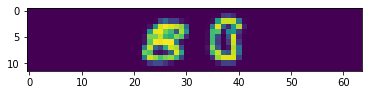

In [ ]:
plt.imshow(x_test[13240,:,:,0])